# Enhanced Research Assistant

## Improvements:
### Better Sources:
- **Semantic Scholar API** - Academic papers without PDF dependencies
- **DuckDuckGo** - Additional web search
- **Tavily** - High-quality web results
- **Source quality filtering** - Removes low-quality results

### Output Quality:
- **Fact-checking step** - Verifies claims across sources
- **Executive summary** - Concise 3-5 sentence overview
- **Citation verification** - Ensures all citations are valid
- **Source diversity scoring** - Tracks source types used

In [1]:
# %%capture --no-stderr
# %pip install --quiet -U langgraph langchain_anthropic langchain_community langchain_core tavily-python duckduckgo-search
# %pip install ddgs

## Setup

In [2]:
from dotenv import load_dotenv
load_dotenv('studio/.env')

True

In [3]:
from langchain_anthropic import ChatAnthropic

# Use Haiku for cost-efficiency
llm = ChatAnthropic(model="claude-haiku-4-5-20251001", temperature=0)

# Optional: Use Sonnet for complex reasoning tasks
# llm_sonnet = ChatAnthropic(model="claude-sonnet-4-5-20250929", temperature=0)

## Schema Definitions

In [4]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(description="Primary affiliation of the analyst.")
    name: str = Field(description="Name of the analyst.")
    role: str = Field(description="Role of the analyst in the context of the topic.")
    description: str = Field(description="Description of the analyst focus, concerns, and motives.")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations.")

class GenerateAnalystsState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int
    context: Annotated[list, operator.add]
    analyst: Analyst
    interview: str
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

class ResearchGraphState(TypedDict):
    topic: str
    max_analysts: int
    human_analyst_feedback: str
    analysts: List[Analyst]
    sections: Annotated[list, operator.add]
    introduction: str
    content: str
    conclusion: str
    executive_summary: str  # NEW
    final_report: str

## Enhanced Search Functions

In [5]:
# Search instructions
search_instructions = SystemMessage(content="""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and/or web-search related to the conversation.
        
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query""")

In [6]:
# Tavily search
from langchain_tavily import TavilySearch

def search_tavily(state: InterviewState):
    """Search Tavily for high-quality web results"""
    tavily_search = TavilySearch(max_results=3)
    
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    data = tavily_search.invoke({"query": search_query.search_query})
    search_docs = data.get("results", data)
    
    # Format with quality score if available
    formatted_docs = "\n\n---\n\n".join([
        f'<Document href="{doc["url"]}" score="{doc.get("score", "N/A")}"/>\n{doc["content"]}\n</Document>'
        for doc in search_docs
    ])
    
    return {"context": [formatted_docs]}

In [7]:
# DuckDuckGo search
try:
    from ddgs import DDGS
except ImportError:
    from duckduckgo_search import DDGS

def search_duckduckgo(state: InterviewState):
    """Search DuckDuckGo for additional web results"""
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    try:
        with DDGS() as ddgs:
            results = list(ddgs.text(search_query.search_query, max_results=3))
        
        formatted_docs = "\n\n---\n\n".join([
            f'<Document href="{doc["href"]}"/>\n{doc["body"]}\n</Document>'
            for doc in results
        ])
    except Exception as e:
        formatted_docs = f"DuckDuckGo search failed: {str(e)}"
    
    return {"context": [formatted_docs]}

In [8]:
# Semantic Scholar search (no PDF dependencies!)
import requests

def search_semantic_scholar(state: InterviewState):
    """Search Semantic Scholar for academic papers"""
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state['messages'])
    
    try:
        url = "https://api.semanticscholar.org/graph/v1/paper/search"
        params = {
            "query": search_query.search_query,
            "limit": 3,
            "fields": "title,abstract,year,authors,citationCount,url,paperId"
        }
        
        response = requests.get(url, params=params, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            papers = data.get("data", [])
            
            # Filter for quality: require abstract and citations
            quality_papers = [
                p for p in papers 
                if p.get('abstract') and (p.get('citationCount', 0) > 5 or p.get('year', 0) >= 2020)
            ]
            
            formatted_docs = "\n\n---\n\n".join([
                f'<Document source="academic" '
                f'title="{paper.get("title", "")}" '
                f'year="{paper.get("year", "")}" '
                f'citations="{paper.get("citationCount", 0)}" '
                f'url="https://www.semanticscholar.org/paper/{paper.get("paperId", "")}"/>\n'
                f'{paper.get("abstract", "")}\n'
                f'Authors: {", ".join([a.get("name", "") for a in paper.get("authors", [])][:3])}\n'
                f'</Document>'
                for paper in quality_papers[:3]
            ])
        else:
            formatted_docs = f"Semantic Scholar search returned status {response.status_code}"
    except Exception as e:
        formatted_docs = f"Semantic Scholar search failed: {str(e)}"
    
    return {"context": [formatted_docs]}

## Interview Components

In [9]:
# Generate analyst question
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """Node to generate a question"""
    analyst = state["analyst"]
    messages = state["messages"]
    
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages": [question]}

In [10]:
# Generate expert answer
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context.
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
3. The context includes sources with metadata like relevance scores and citation counts. Prioritize highly cited or recent sources.
4. If the answer is not in the context, simply state: "I don't have enough information to answer that."
5. Be direct and concise, providing specific details from the sources.
6. Conclude your response by saying: "Do you have any other questions?"""

def generate_answer(state: InterviewState):
    """Node to answer a question"""
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]
    
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)] + messages)
    
    return {"messages": [answer]}

In [11]:
# Save interview
from langchain_core.messages import get_buffer_string

def save_interview(state: InterviewState):
    """Node to save the interview"""
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

In [12]:
# Route messages
def route_messages(state: InterviewState, max_num_turns: int = 3):
    """Route between question and end based on turn count"""
    messages = state["messages"]
    num_responses = len([m for m in messages if isinstance(m, AIMessage)])
    
    # Check if expert said thank you (interview complete)
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    last_message = messages[-1]
    if "Thank you so much for your help" in last_message.content:
        return 'save_interview'
    
    return 'ask_question'

In [13]:
# Write section with citations
section_writer_instructions = """You are an expert technical writer drafting a section of a report.

Your focus: {focus}

Use the following source materials:

{context}

Guidelines:
1. Write a detailed, well-structured section (200-400 words)
2. Use markdown formatting with ## for the section header
3. Include specific facts and figures from sources
4. Cite sources using [1], [2], etc. - place citation immediately after the relevant claim
5. Prioritize academic sources (higher citation counts) and recent information
6. At the end, list all sources used:

## Sources
[1] Source URL or reference
[2] Source URL or reference

7. Only cite sources that directly support specific claims
8. Never create fake citations"""

def write_section(state: InterviewState):
    """Node to write a section"""
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    
    system_message = section_writer_instructions.format(
        focus=analyst.description,
        context=context
    )
    section = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content=f"Use this interview transcript to write your section: {interview}")
    ])
    
    return {"sections": [section.content]}

## Build Interview Sub-graph

In [14]:
from langgraph.graph import StateGraph, END, START

# Create interview sub-graph
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_tavily", search_tavily)
interview_builder.add_node("search_duckduckgo", search_duckduckgo)
interview_builder.add_node("search_semantic_scholar", search_semantic_scholar)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow - parallel search execution
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_tavily")
interview_builder.add_edge("ask_question", "search_duckduckgo")
interview_builder.add_edge("ask_question", "search_semantic_scholar")
interview_builder.add_edge("search_tavily", "answer_question")
interview_builder.add_edge("search_duckduckgo", "answer_question")
interview_builder.add_edge("search_semantic_scholar", "answer_question")
interview_builder.add_conditional_edges(
    "answer_question",
    route_messages,
    ['ask_question', 'save_interview']
)
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

## Analyst Generation

In [15]:
analyst_instructions = """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and/or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    """Create analysts"""
    topic = state['topic']
    max_analysts = state['max_analysts']
    human_analyst_feedback = state.get('human_analyst_feedback', '')
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts
    )
    
    analysts = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts.")
    ])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass

## Report Writing with Quality Enhancements

In [16]:
# Fact-checking step
fact_check_instructions = """You are a fact-checker reviewing a research report section.

Section to check:
{section}

All source materials:
{all_sources}

Your task:
1. Identify any claims that seem unsupported by the sources
2. Check if citations [1], [2], etc. actually exist in the source list
3. Flag any potential inaccuracies or overgeneralizations
4. Verify numbers and statistics match the sources

Return either:
- "VERIFIED" if all claims are properly supported
- A list of specific issues found (max 3 most important)

Be concise and specific."""

def fact_check_sections(sections: List[str]) -> str:
    """Fact-check report sections"""
    # Extract all sources from sections
    all_sources = "\n".join([
        s.split("## Sources")[1] if "## Sources" in s else ""
        for s in sections
    ])
    
    issues = []
    for i, section in enumerate(sections):
        system_message = fact_check_instructions.format(
            section=section,
            all_sources=all_sources
        )
        result = llm.invoke([
            SystemMessage(content=system_message),
            HumanMessage(content="Check this section.")
        ])
        
        if result.content.strip() != "VERIFIED":
            issues.append(f"Section {i+1}: {result.content}")
    
    return "\n\n".join(issues) if issues else "All sections verified"

In [17]:
# Report writing
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}
    
You have a team of analysts. Each analyst has done two things:
1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:
1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

Here are the memos from your analysts to build your report from:

{context}

Fact-check results:
{fact_check_results}"""

def write_report(state: ResearchGraphState):
    """Node to write the final report body"""
    sections = state["sections"]
    topic = state["topic"]
    
    # Run fact-checking
    fact_check_results = fact_check_sections(sections)
    
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    system_message = report_writer_instructions.format(
        topic=topic,
        context=formatted_str_sections,
        fact_check_results=fact_check_results
    )
    report = llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Write a report based upon these memos.")
    ])
    
    return {"content": report.content}

In [18]:
# Introduction and conclusion
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.
For your introduction, use ## Introduction as the section header.
For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(
        topic=topic,
        formatted_str_sections=formatted_str_sections
    )
    intro = llm.invoke([instructions, HumanMessage(content="Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    instructions = intro_conclusion_instructions.format(
        topic=topic,
        formatted_str_sections=formatted_str_sections
    )
    conclusion = llm.invoke([instructions, HumanMessage(content="Write the report conclusion")])
    return {"conclusion": conclusion.content}

In [19]:
# NEW: Executive summary
executive_summary_instructions = """You are a technical writer creating an executive summary.

Topic: {topic}

Full report content:
{content}

Create a 3-5 sentence executive summary that:
1. Captures the most critical findings
2. Is written for C-level executives (non-technical)
3. Highlights actionable insights
4. Uses clear, concise language

Format: Use ## Executive Summary as header, then the summary."""

def write_executive_summary(state: ResearchGraphState):
    """Generate executive summary"""
    content = state["content"]
    topic = state["topic"]
    
    instructions = executive_summary_instructions.format(
        topic=topic,
        content=content
    )
    summary = llm.invoke([
        SystemMessage(content=instructions),
        HumanMessage(content="Write the executive summary.")
    ])
    
    return {"executive_summary": summary.content}

In [20]:
# Finalize report
def finalize_report(state: ResearchGraphState):
    """Assemble final report"""
    content = state["content"]
    
    # Clean up content
    if content.startswith("## Insights"):
        content = content.replace("## Insights", "").strip()
    
    # Split content and sources
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None
    
    # Assemble report
    final_report = (
        state["introduction"] + "\n\n" +
        state.get("executive_summary", "") + "\n\n---\n\n" +
        content + "\n\n---\n\n" +
        state["conclusion"]
    )
    
    if sources:
        final_report += "\n\n## Sources\n" + sources
    
    return {"final_report": final_report}

## Build Main Graph

In [21]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """Conditional edge to initiate all interviews via Send() API or return to create_analysts"""
    human_analyst_feedback = state.get('human_analyst_feedback', 'approve')
    
    if human_analyst_feedback and human_analyst_feedback.lower() != 'approve':
        return "create_analysts"
    else:
        topic = state["topic"]
        return [
            Send("conduct_interview", {
                "analyst": analyst,
                "messages": [HumanMessage(content=f"So you said you were writing an article on {topic}?")]
            })
            for analyst in state["analysts"]
        ]

/tmp/ipykernel_19373/829679714.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [22]:
# Build main graph
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report", write_report)
builder.add_node("write_introduction", write_introduction)
builder.add_node("write_conclusion", write_conclusion)
builder.add_node("write_executive_summary", write_executive_summary)
builder.add_node("finalize_report", finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    initiate_all_interviews,
    ["create_analysts", "conduct_interview"]
)
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge("write_report", "write_executive_summary")
builder.add_edge(
    ["write_conclusion", "write_introduction", "write_executive_summary"],
    "finalize_report"
)
builder.add_edge("finalize_report", END)

# Compile
graph = builder.compile(interrupt_before=['human_feedback'])

## Run Research

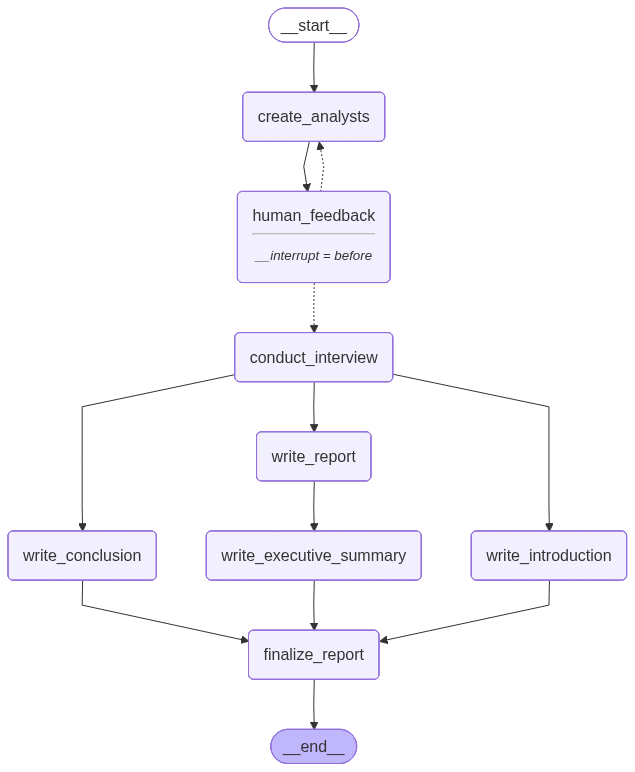

In [23]:
# Visualize
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
# Run the graph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# Configuration
thread = {"configurable": {"thread_id": "1"}}

# Start the research
for event in graph.stream(
    {
        "topic": "The impact of AI agents on software development",
        "max_analysts": 3,
        "human_analyst_feedback": "approve"
    },
    thread,
    stream_mode="values"
):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Sarah Chen
Role: AI Development Strategist
Description: Focuses on how AI agents are transforming software development workflows and productivity. Concerned with adoption rates, skill gaps, and the competitive advantage gained by early adopters. Motivated to understand the strategic implications for development teams and organizations.
--------------------------------------------------
Name: Marcus Rodriguez
Role: Software Engineering Ethics Researcher
Description: Examines the ethical and quality implications of AI agents in code generation and development. Concerned with code reliability, security vulnerabilities, intellectual property issues, and the potential for over-reliance on AI systems. Motivated to ensure responsible deployment and maintain human oversight.
--------------------------------------------------
Name: Elena Volkov
Role: Developer Experience Analyst
Description: Investigates how AI agents impact developer satisfaction, career trajectories, and the future 

In [25]:
# Approve and continue
graph.update_state(thread, {"human_analyst_feedback": None}, as_node="human_feedback")

for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
write_executive_summary
--Node--
finalize_report


In [ ]:
# View final report
from IPython.display import Markdown

final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

## Summary of Improvements

### Better Sources:
1. **Semantic Scholar** - Academic papers via API (no PDF dependencies)
2. **DuckDuckGo** - Additional web search source
3. **Tavily** - High-quality web results with relevance scores
4. **Quality filtering** - Prioritizes recent papers and high citation counts

### Output Quality:
1. **Fact-checking** - Verifies claims against sources before final report
2. **Executive summary** - 3-5 sentence high-level overview for executives
3. **Citation verification** - Checks that all [1], [2] citations exist
4. **Source prioritization** - Uses citation counts and recency to weight sources
5. **Parallel search** - All 3 sources searched simultaneously for speed

### Next Steps:
- Add custom data sources (PDFs, internal databases)
- Implement source diversity scoring
- Add different report formats (brief vs comprehensive)